In [1]:
%matplotlib inline
import random
import operator

import numpy as np
import matplotlib.pyplot as plt

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp


C:\Users\gwgwa\Anaconda3\lib\site-packages\deap\tools\_hypervolume\pyhv.py:33: ImportWarning: Falling back to the python version of hypervolume module. Expect this to be very slow.
  "module. Expect this to be very slow.", ImportWarning)


In [2]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,-1.0))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

In [3]:
random.seed(25)

pset = gp.PrimitiveSet("MAIN", arity=1)
#pset.addPrimitive(np.add, arity=2)
#pset.addPrimitive(np.subtract, arity=2)
#pset.addPrimitive(np.multiply, arity=2)
#pset.addPrimitive(np.negative, arity=1)
pset.addPrimitive(np.sin, arity=1)
pset.addPrimitive(np.cos, arity=1)
pset.addPrimitive(np.tan, arity=1)
pset.renameArguments(ARG0='x')

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

In [4]:
def evalSymbReg(individual, points, pset):
    func = gp.compile(expr=individual, pset=pset)
    sqerrors = (func(points)-(np.negative(points) + np.sin(points**2) + np.tan(points**3) - np.cos(points)))**2

    return (np.sqrt(np.sum(sqerrors) / len(points)), len(individual))


toolbox.register("evaluate", evalSymbReg, points=np.linspace(-1, 1, 1000), pset=pset)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

In [5]:
def pareto_dominance(ind1, ind2):
    not_equal = False
    for value_1, value_2 in zip(ind1.fitness.values, ind2.fitness.values):
        if value_1 > value_2:
            return False
        elif value_1 < value_2:
            not_equal = True
    return not_equal

In [6]:
pop = toolbox.population(n=300)

fitnesses = list(map(toolbox.evaluate, pop))
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

a_given_individual = toolbox.population(n=1)[0]
a_given_individual.fitness.values = toolbox.evaluate(a_given_individual)

In [7]:
dominated = [ind for ind in pop if pareto_dominance(a_given_individual, ind)]
dominators = [ind for ind in pop if pareto_dominance(ind, a_given_individual)]
others = [ind for ind in pop if not ind in dominated and not ind in dominators]

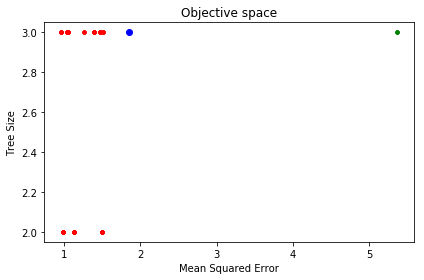

In [8]:
for ind in dominators: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'r.', alpha=0.7)
for ind in dominated: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'g.', alpha=0.7)
for ind in others: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'k.', alpha=0.7, ms=3)
plt.plot(a_given_individual.fitness.values[0], a_given_individual.fitness.values[1], 'bo', ms=6);
plt.xlabel('Mean Squared Error');plt.ylabel('Tree Size');
plt.title('Objective space');
plt.tight_layout()
plt.show()

In [9]:
NGEN = 50
MU = 50
LAMBDA = 100
CXPB = 0.5
MUTPB = 0.2

pop = toolbox.population(n=MU)
hof = tools.ParetoFront()
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean, axis=0)
stats.register("std", np.std, axis=0)
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)

pop, logbook = algorithms.eaMuPlusLambda(pop, toolbox, MU, LAMBDA, CXPB, MUTPB, NGEN, stats,
                          halloffame=hof)

gen	nevals	avg                    	std                    	min                    	max                    
0  	50    	[1.34097753 2.4       ]	[0.63407263 0.48989795]	[0.96166056 2.        ]	[5.36937813 3.        ]
1  	72    	[1.11572551 2.38      ]	[0.16705322 0.52497619]	[0.96166056 2.        ]	[1.50104761 4.        ]
2  	64    	[1.0029283 2.18     ]  	[0.03900901 0.51730069]	[0.96166056 1.        ]	[1.12913912 4.        ]
3  	68    	[0.98234987 2.12      ]	[0.00959361 0.38157568]	[0.96166056 1.        ]	[1.01875976 3.        ]
4  	63    	[0.97469211 2.44      ]	[0.01155124 0.49638695]	[0.96166056 2.        ]	[0.98493119 3.        ]
5  	64    	[0.96724551 2.76      ]	[0.00993849 0.42708313]	[0.96166056 2.        ]	[0.98493119 3.        ]
6  	69    	[0.95962234 3.12      ]	[0.00636609 0.38157568]	[0.93007479 3.        ]	[0.96166056 5.        ]
7  	68    	[0.9547711 3.4      ]  	[0.00955798 0.56568542]	[0.93007479 3.        ]	[0.96166056 5.        ]
8  	68    	[0.94624412 3.9       ]	[0

Best individual is: sin(sin(sin(sin(sin(sin(sin(sin(sin(sin(sin(sin(sin(sin(sin(sin(sin(x)))))))))))))))))
with fitness: (0.8520057573415855, 18.0)


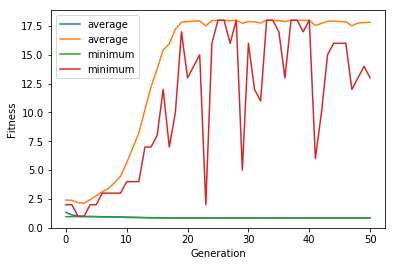

In [10]:
print("Best individual is: %s\nwith fitness: %s" % (hof[0], hof[0].fitness))
gen, avg, min_, max_ = logbook.select("gen", "avg", "min", "max")
plt.plot(gen, avg, label="average")
plt.plot(gen, min_, label="minimum")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="upper left")
plt.show()

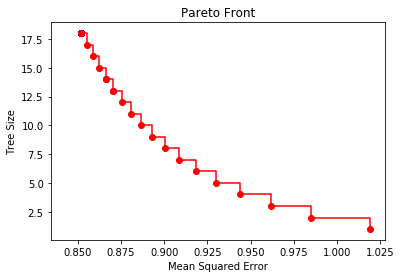

Area Under Curve: 1.0982901691790423


In [11]:
"""Split fitness values into separate lists"""
fitness_1 = [ind.fitness.values[0] for ind in hof]
fitness_2 = [ind.fitness.values[1] for ind in hof]
pop_1 = [ind.fitness.values[0] for ind in pop]
pop_2 = [ind.fitness.values[1] for ind in pop]

'''Print dominated population for debugging'''
# for ind in pop:
#     print(ind.fitness)

plt.scatter(pop_1, pop_2, color='b')
plt.scatter(fitness_1, fitness_2, color='r')
plt.plot(fitness_1, fitness_2, color='r', drawstyle='steps-post')
plt.xlabel("Mean Squared Error")
plt.ylabel("Tree Size")
plt.title("Pareto Front")
plt.show()

f1 = np.array(fitness_1)
f2 = np.array(fitness_2)

"""Calculate area under curve with least squares method"""
print("Area Under Curve: %s" % (np.sum(np.abs(np.diff(f1))*f2[:-1])))